In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'
internet_path = '/content/drive/MyDrive/Colab Notebooks/tomato_images2/'


BATCH_SIZE = 256
IMG_SIZE = (75, 75)
SEED = 42

In [10]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

valid2_gen, test2_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    seed=SEED,
    validation_split=0.5,
    image_size=IMG_SIZE,
    subset="both",
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


test3_gen = tf.keras.utils.image_dataset_from_directory(
    internet_path,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid2_gen = valid2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test3_gen = test3_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid3_gen = test3_gen

Found 12803 files belonging to 9 classes.
Using 10883 files for training.
Using 1920 files for validation.
Found 37455 files belonging to 9 classes.
Using 18728 files for training.
Using 18727 files for validation.
Found 35 files belonging to 9 classes.


In [21]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import matplotlib.pyplot as plt

In [6]:
class TripleValidationCallback(Callback):
    def __init__(self, validation_gen2, validation_gen3):
        super().__init__()
        self.validation_gen2 = validation_gen2
        self.validation_gen3 = validation_gen3
        self.history = {'val2_loss': [], 'val2_acc': [], 'val3_loss': [], 'val3_acc': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss2, val_acc2 = self.model.evaluate(self.validation_gen2, verbose=0)
        val_loss3, val_acc3 = self.model.evaluate(self.validation_gen3, verbose=0)
        logs['val2_loss'] = val_loss2
        logs['val2_acc'] = val_acc2
        logs['val3_loss'] = val_loss3
        logs['val3_acc'] = val_acc3
        self.history['val2_loss'].append(val_loss2)
        self.history['val2_acc'].append(val_acc2)
        self.history['val3_loss'].append(val_loss3)
        self.history['val3_acc'].append(val_acc3)


In [29]:
def create_and_train_model(base_model, model_filename, freeze_layers=True, epoch=50):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers[:10]:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    # x = Dense(64, activation='relu')(x)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val2_loss', patience=40, verbose=1, mode='min', restore_best_weights=True)

    triple_val_callback = TripleValidationCallback(validation_gen2=valid2_gen, validation_gen3=valid3_gen)

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epoch, callbacks=[triple_val_callback, early_stopping])

    # Combine Keras history with custom callback history
    history = history.history
    history.update(triple_val_callback.history)

    # Save the model
    model.save(model_filename)

    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.plot(history['val2_loss'], label='Validation2 Loss')
    plt.plot(history['val3_loss'], label='Validation3 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracies
    plt.figure()
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation1 Accuracy')
    plt.plot(history['val2_acc'], label='Validation2 Accuracy')
    plt.plot(history['val3_acc'], label='Validation3 Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Measure inference time 3
    start_time = time.time()
    _, accuracy3 = model.evaluate(test3_gen)
    end_time = time.time()
    inference_time3 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    # Print results
    print(f"Model: {model_filename}")
    print(f"Params: {num_params}")
    print(f"Inference Time: {inference_time}")
    print(f"Accuracy: {accuracy}")
    print(f"Inference Time2: {inference_time2}")
    print(f"Accuracy2: {accuracy2}")
    print(f"Inference Time3: {inference_time3}")
    print(f"Accuracy3: {accuracy3}")



29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/50
289/289 [==============================] - 102s 132ms/step - loss: 0.5349 - accuracy: 0.8313 - val_loss: 1.4314 - val_accuracy: 0.6790 - val2_loss: 1.6001 - val2_acc: 0.6410 - val3_loss: 8.0652 - val3_acc: 0.2286
Epoch 2/50
289/289 [==============================] - 28s 97ms/step - loss: 0.2121 - accuracy: 0.9279 - val_loss: 1.0419 - val_accuracy: 0.7244 - val2_loss: 1.8607 - val2_acc: 0.6013 - val3_loss: 7.9497 - val3_acc: 0.2571
Epoch 3/50
289/289 [==============================] - 28s 98ms/step - loss: 0.1376 - accuracy: 0.9551 - val_loss: 0.6750 - val_accuracy: 0.8246 - val2_loss: 1.0625 - val2_acc: 0.7273 - val3_loss: 5.6934 - val3_acc: 0.2286
Epoch 4/50
289/289 [==============================] - 28s 97ms/step - loss: 0.0964 - accuracy: 0.9688 - val_loss: 0.3488 - val_accuracy: 0.8906 - val2_loss: 0.9138 - val2_acc: 0.7874 - val3_loss: 9.6006 - val3_acc: 0.3429
Epoch 5/50
289/289 [=========================

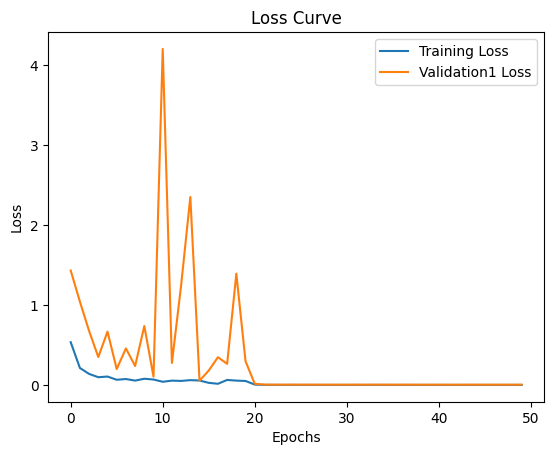

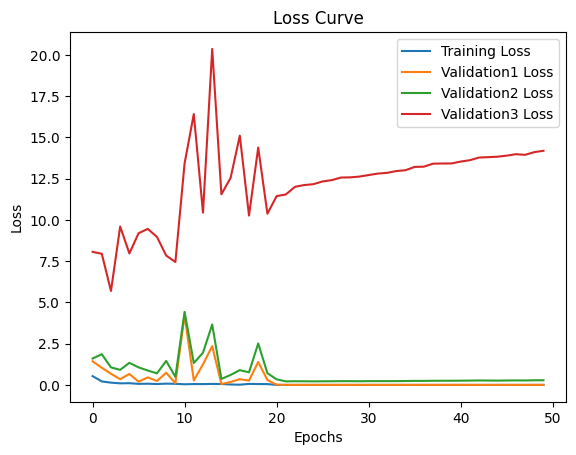

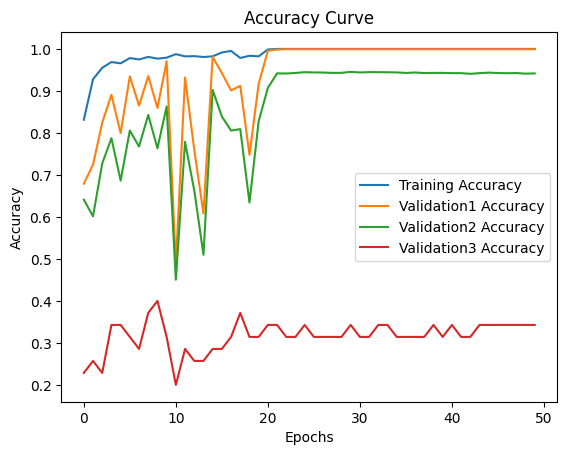

2/2 [==============================] - 0s 18ms/step - loss: 14.1921 - accuracy: 0.3429
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_50e.model
Params: 7046729
Inference Time: 0.9002220630645752
Accuracy: 0.9911458492279053
Inference Time2: 8.806164741516113
Accuracy2: 0.9454264044761658
Inference Time3: 0.05300736427307129
Accuracy3: 0.34285715222358704


In [8]:
# Create and train DenseNet121 75 32
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_50e.model', freeze_layers=False)

Epoch 1/50
36/36 [==============================] - 66s 260ms/step - loss: 0.5105 - accuracy: 0.8309 - val_loss: 5.6645 - val_accuracy: 0.2917 - val2_loss: 5.7644 - val2_acc: 0.2813 - val3_loss: 8.6011 - val3_acc: 0.2286
Epoch 2/50
36/36 [==============================] - 5s 154ms/step - loss: 0.0793 - accuracy: 0.9747 - val_loss: 5.5452 - val_accuracy: 0.4557 - val2_loss: 6.1173 - val2_acc: 0.3911 - val3_loss: 14.6504 - val3_acc: 0.1143
Epoch 3/50
36/36 [==============================] - 5s 154ms/step - loss: 0.0471 - accuracy: 0.9843 - val_loss: 5.3787 - val_accuracy: 0.4961 - val2_loss: 6.6514 - val2_acc: 0.4034 - val3_loss: 21.2825 - val3_acc: 0.0857
Epoch 4/50
36/36 [==============================] - 5s 153ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 1.3081 - val_accuracy: 0.7591 - val2_loss: 2.5036 - val2_acc: 0.6312 - val3_loss: 7.8148 - val3_acc: 0.2571
Epoch 5/50
36/36 [==============================] - 6s 157ms/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.585

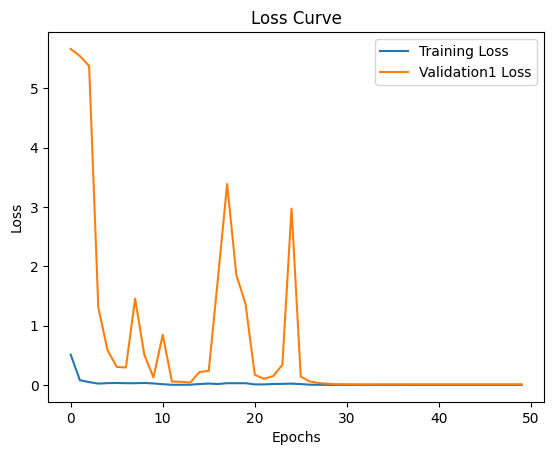

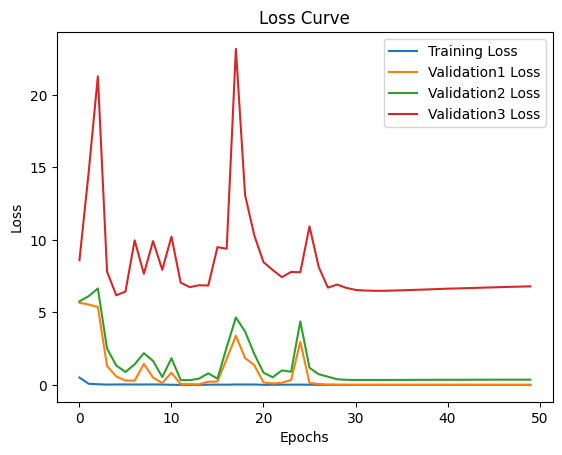

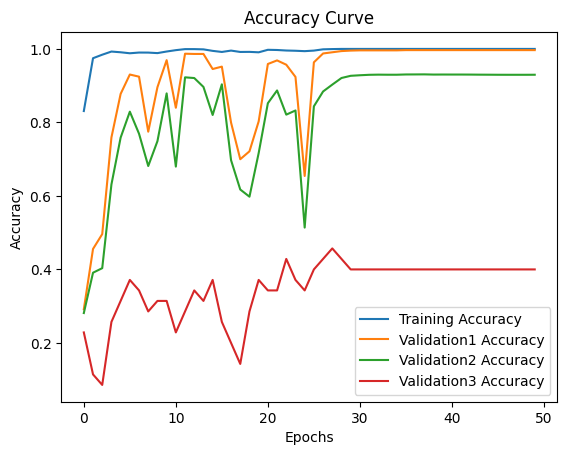

1/1 [==============================] - 0s 27ms/step - loss: 6.7979 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_50e_dense256.model
Params: 7302217
Inference Time: 0.43440699577331543
Accuracy: 0.9927083253860474
Inference Time2: 2.487302780151367
Accuracy2: 0.9317562580108643
Inference Time3: 0.03902578353881836
Accuracy3: 0.4000000059604645


In [14]:
# Create and train DenseNet121 75 256 dense256
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_50e_dense256.model', freeze_layers=False)

Epoch 1/50
36/36 [==============================] - 58s 210ms/step - loss: 0.6068 - accuracy: 0.8035 - val_loss: 7.7679 - val_accuracy: 0.2480 - val2_loss: 8.0750 - val2_acc: 0.2127 - val3_loss: 12.2744 - val3_acc: 0.0286
Epoch 2/50
36/36 [==============================] - 6s 156ms/step - loss: 0.0981 - accuracy: 0.9669 - val_loss: 3.9024 - val_accuracy: 0.5417 - val2_loss: 4.5714 - val2_acc: 0.4727 - val3_loss: 11.6211 - val3_acc: 0.1143
Epoch 3/50
36/36 [==============================] - 6s 157ms/step - loss: 0.0470 - accuracy: 0.9842 - val_loss: 7.8955 - val_accuracy: 0.3587 - val2_loss: 8.5389 - val2_acc: 0.3232 - val3_loss: 15.2430 - val3_acc: 0.0857
Epoch 4/50
36/36 [==============================] - 6s 156ms/step - loss: 0.0282 - accuracy: 0.9899 - val_loss: 0.2910 - val_accuracy: 0.9225 - val2_loss: 0.8319 - val2_acc: 0.8324 - val3_loss: 9.0787 - val3_acc: 0.2571
Epoch 5/50
36/36 [==============================] - 5s 154ms/step - loss: 0.0270 - accuracy: 0.9900 - val_loss: 1.24

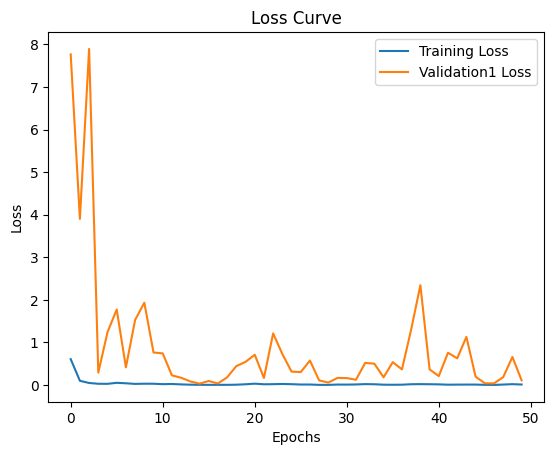

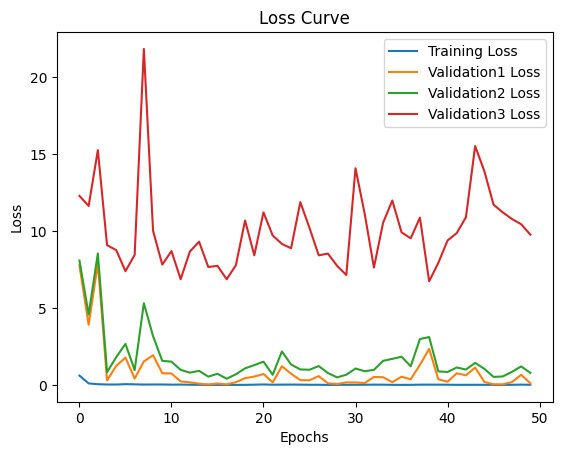

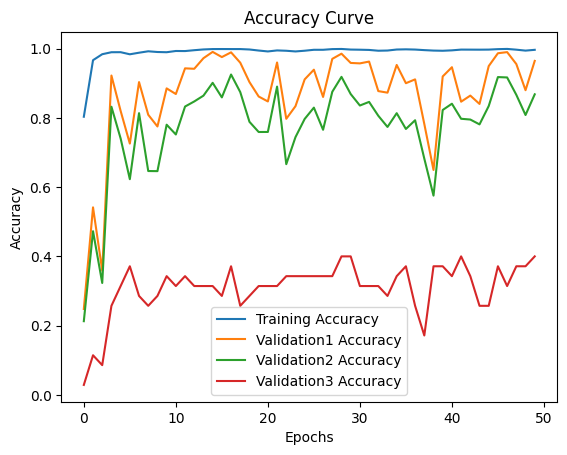

1/1 [==============================] - 0s 25ms/step - loss: 9.7581 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_50e_dense256dense64.model
Params: 7316937
Inference Time: 0.25734686851501465
Accuracy: 0.9463541507720947
Inference Time2: 2.032493829727173
Accuracy2: 0.8741389513015747
Inference Time3: 0.03552699089050293
Accuracy3: 0.4000000059604645


In [17]:
# Create and train DenseNet121 75 256 dense256dense64
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_50e_dense256dense64.model', freeze_layers=False)

Epoch 1/100
36/36 [==============================] - 61s 217ms/step - loss: 0.6025 - accuracy: 0.8024 - val_loss: 7.6110 - val_accuracy: 0.2559 - val2_loss: 7.6741 - val2_acc: 0.2237 - val3_loss: 15.3811 - val3_acc: 0.0571
Epoch 2/100
36/36 [==============================] - 6s 157ms/step - loss: 0.0910 - accuracy: 0.9710 - val_loss: 5.6415 - val_accuracy: 0.4414 - val2_loss: 6.4939 - val2_acc: 0.3972 - val3_loss: 23.7955 - val3_acc: 0.0857
Epoch 3/100
36/36 [==============================] - 6s 157ms/step - loss: 0.0580 - accuracy: 0.9800 - val_loss: 6.2647 - val_accuracy: 0.4219 - val2_loss: 7.7224 - val2_acc: 0.3630 - val3_loss: 16.9162 - val3_acc: 0.0571
Epoch 4/100
36/36 [==============================] - 6s 156ms/step - loss: 0.0409 - accuracy: 0.9850 - val_loss: 1.7176 - val_accuracy: 0.6803 - val2_loss: 2.7576 - val2_acc: 0.5589 - val3_loss: 14.0008 - val3_acc: 0.1714
Epoch 5/100
36/36 [==============================] - 6s 156ms/step - loss: 0.0304 - accuracy: 0.9907 - val_loss

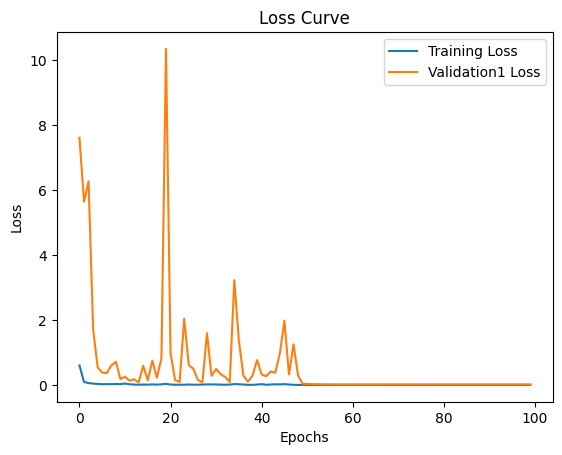

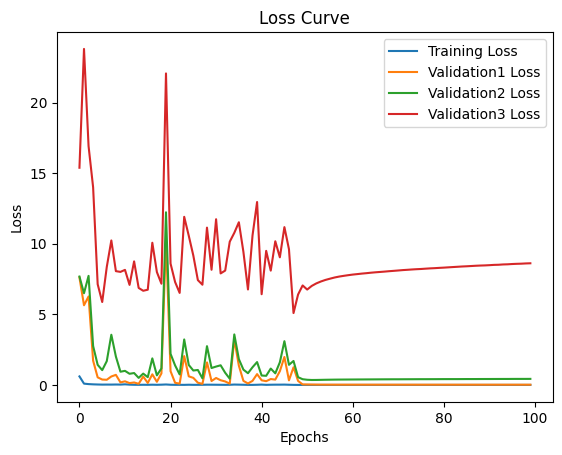

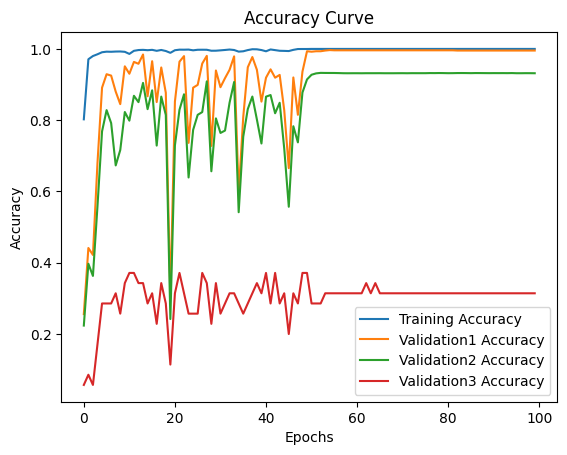

1/1 [==============================] - 0s 26ms/step - loss: 8.6145 - accuracy: 0.3143
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_100e_dense256dense64.model
Params: 7316937
Inference Time: 0.27085137367248535
Accuracy: 0.9895833134651184
Inference Time2: 2.0596108436584473
Accuracy2: 0.9348000288009644
Inference Time3: 0.0370182991027832
Accuracy3: 0.3142857253551483


In [18]:
# Create and train DenseNet121 75 256 dense256dense64
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_100e_dense256dense64.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 11s 140ms/step - loss: 5.3523 - accuracy: 0.4427 - val_loss: 1.6030 - val_accuracy: 0.6302 - val2_loss: 1.7457 - val2_acc: 0.5820 - val3_loss: 18.2712 - val3_acc: 0.2000
Epoch 2/100
36/36 [==============================] - 3s 85ms/step - loss: 1.1873 - accuracy: 0.6876 - val_loss: 0.9394 - val_accuracy: 0.7422 - val2_loss: 1.1392 - val2_acc: 0.6842 - val3_loss: 14.9258 - val3_acc: 0.2571
Epoch 3/100
36/36 [==============================] - 3s 85ms/step - loss: 0.8187 - accuracy: 0.7523 - val_loss: 0.7341 - val_accuracy: 0.7799 - val2_loss: 0.9527 - val2_acc: 0.7169 - val3_loss: 13.7937 - val3_acc: 0.2857
Epoch 4/100
36/36 [==============================] - 3s 86ms/step - loss: 0.6830 - accuracy: 0.7829 - val_loss: 0.6161 - val_accuracy: 0.8158 - val2_loss: 0.8517 - val2_acc: 0.7376 - val3_loss: 13.6934 - val3_acc: 0.3143
Epoch 5/100
36/36 [==============================] - 3s 86ms/step - loss: 0.5926 - accuracy: 0.8073 - val_loss: 0.

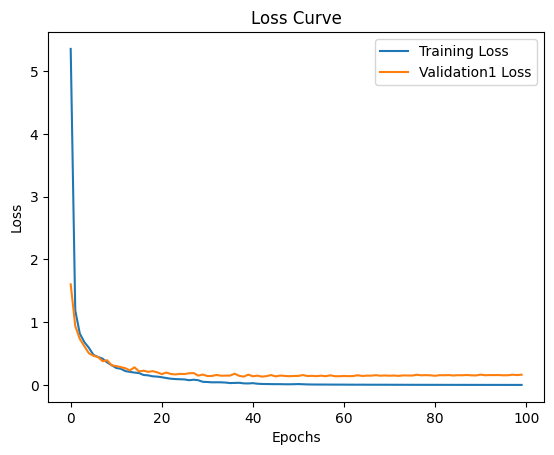

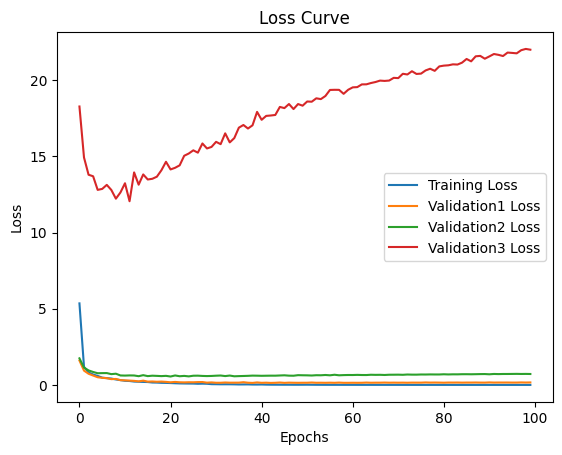

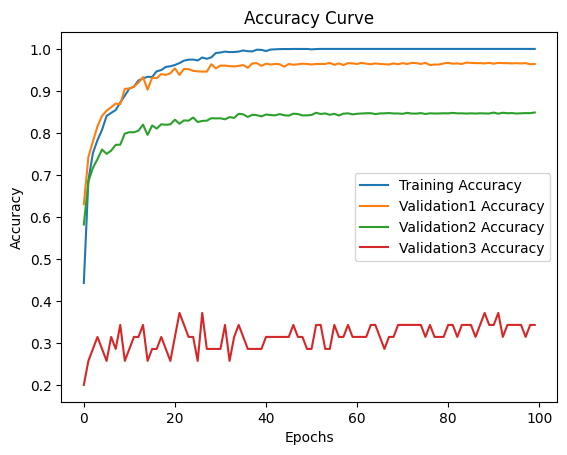

1/1 [==============================] - 0s 22ms/step - loss: 21.9984 - accuracy: 0.3429
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_100e_dense256_unf.model
Params: 7302217
Inference Time: 0.2526204586029053
Accuracy: 0.8671875
Inference Time2: 1.976123332977295
Accuracy2: 0.8458375334739685
Inference Time3: 0.030939102172851562
Accuracy3: 0.34285715222358704


In [20]:
# Create and train DenseNet121 75 256 dense256
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_32b_100e_dense256_unf.model', epoch=100)

Epoch 1/100
36/36 [==============================] - 12s 159ms/step - loss: 3.4143 - accuracy: 0.3966 - val_loss: 1.1573 - val_accuracy: 0.6230 - val2_loss: 1.3090 - val2_acc: 0.5647 - val3_loss: 6.1152 - val3_acc: 0.1714
Epoch 2/100
36/36 [==============================] - 3s 90ms/step - loss: 0.9715 - accuracy: 0.6702 - val_loss: 0.8061 - val_accuracy: 0.7253 - val2_loss: 0.9465 - val2_acc: 0.6781 - val3_loss: 6.9529 - val3_acc: 0.2571
Epoch 3/100
36/36 [==============================] - 3s 93ms/step - loss: 0.7469 - accuracy: 0.7421 - val_loss: 0.6759 - val_accuracy: 0.7721 - val2_loss: 0.8389 - val2_acc: 0.7147 - val3_loss: 6.6618 - val3_acc: 0.2571
Epoch 4/100
36/36 [==============================] - 3s 90ms/step - loss: 0.6139 - accuracy: 0.7892 - val_loss: 0.5628 - val_accuracy: 0.8053 - val2_loss: 0.7380 - val2_acc: 0.7501 - val3_loss: 7.3443 - val3_acc: 0.2857
Epoch 5/100
36/36 [==============================] - 3s 93ms/step - loss: 0.5298 - accuracy: 0.8128 - val_loss: 0.4965

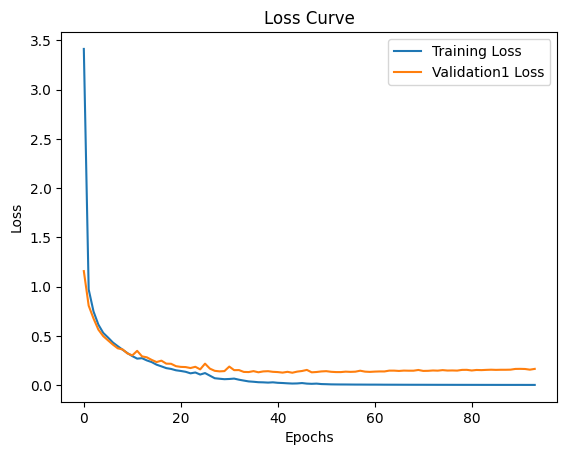

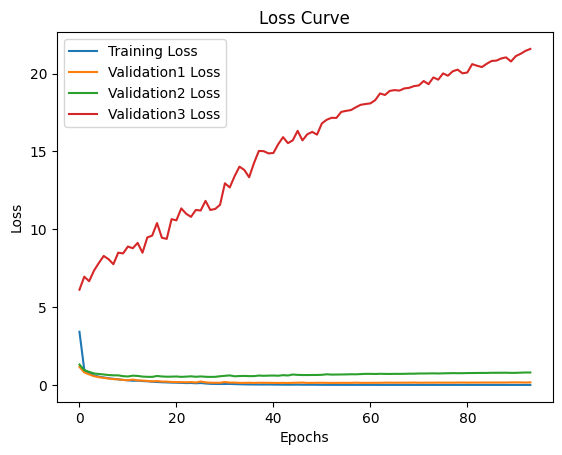

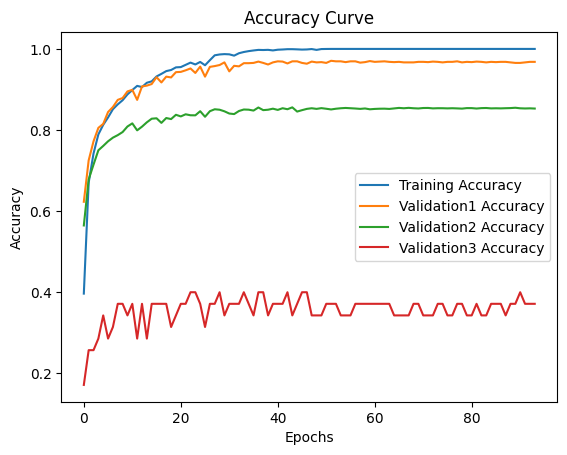

1/1 [==============================] - 0s 24ms/step - loss: 15.5298 - accuracy: 0.3429
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256dense64_unf.model
Params: 7316937
Inference Time: 0.26337361335754395
Accuracy: 0.8598958253860474
Inference Time2: 2.0513503551483154
Accuracy2: 0.8504298329353333
Inference Time3: 0.0341031551361084
Accuracy3: 0.34285715222358704


In [26]:
# Create and train DenseNet121 75 256 dense256dense64 unf
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256dense64_unf.model', epoch=100)

Epoch 1/100
36/36 [==============================] - 61s 222ms/step - loss: 0.4987 - accuracy: 0.8435 - val_loss: 9.2148 - val_accuracy: 0.3477 - val2_loss: 10.3624 - val2_acc: 0.3122 - val3_loss: 24.9943 - val3_acc: 0.0286
Epoch 2/100
36/36 [==============================] - 6s 158ms/step - loss: 0.0856 - accuracy: 0.9716 - val_loss: 5.8572 - val_accuracy: 0.4701 - val2_loss: 7.2090 - val2_acc: 0.4056 - val3_loss: 15.8118 - val3_acc: 0.0857
Epoch 3/100
36/36 [==============================] - 6s 161ms/step - loss: 0.0383 - accuracy: 0.9867 - val_loss: 3.6672 - val_accuracy: 0.5990 - val2_loss: 4.3930 - val2_acc: 0.5309 - val3_loss: 12.4031 - val3_acc: 0.2000
Epoch 4/100
36/36 [==============================] - 6s 158ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.6972 - val_accuracy: 0.8594 - val2_loss: 1.2870 - val2_acc: 0.7708 - val3_loss: 10.8898 - val3_acc: 0.2000
Epoch 5/100
36/36 [==============================] - 6s 160ms/step - loss: 0.0474 - accuracy: 0.9845 - val_los

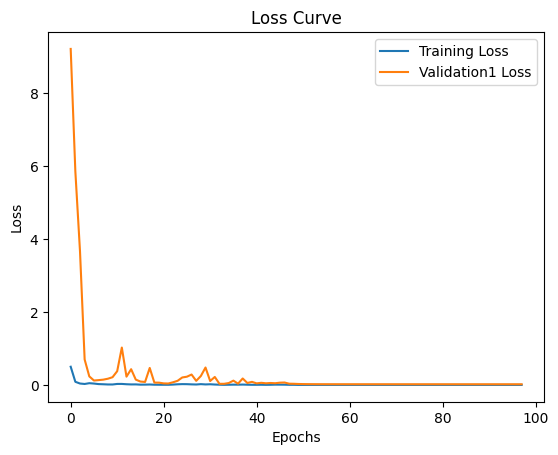

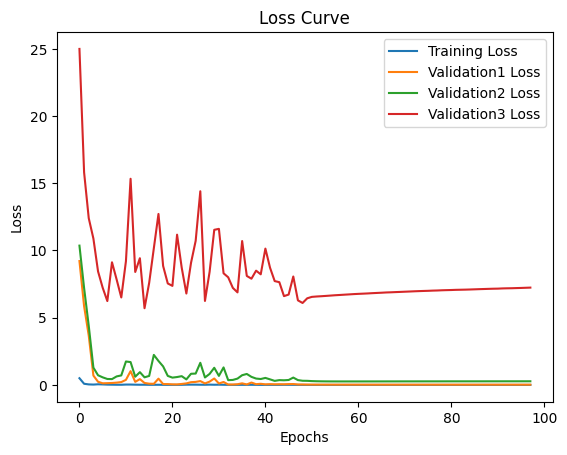

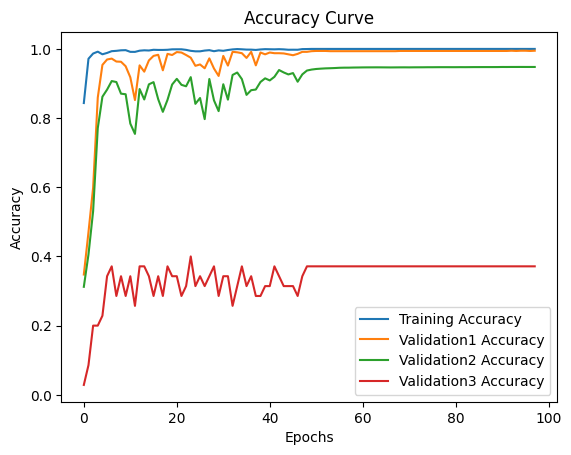

1/1 [==============================] - 0s 24ms/step - loss: 6.7130 - accuracy: 0.3714
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_100e_dense256_unf10.model
Params: 7302217
Inference Time: 0.2584235668182373
Accuracy: 0.9906250238418579
Inference Time2: 2.0734872817993164
Accuracy2: 0.9508196711540222
Inference Time3: 0.03440141677856445
Accuracy3: 0.37142857909202576


In [31]:
# Create and train DenseNet121 75 256 dense256 unf10
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_100e_dense256_unf10.model', epoch=100)